In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 


# Loading the dataset

In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

# Deeper Network (2 hidden layers)

To get from the perceptron to mlp we expanded the model by scaling the input dimension. Now we can try to make it deeper, with more operations happening in series. <br>


_Curious note: biological neurons fire around 100 times a second, it takes a human 100ms to identify an object, so it stands to reason that a 10 layer network may be able to do complex tasks._

Millions of parameters: 0.07


c:\Users\lucam\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch ___0 - Loss: 4.195
Epoch _300 - Loss: 2.692
Epoch _600 - Loss: 2.426
Epoch _900 - Loss: 2.282
Epoch 1200 - Loss: 2.188
Epoch 1500 - Loss: 2.085
Epoch 1800 - Loss: 1.986
Epoch 2100 - Loss: 1.948
Epoch 2400 - Loss: 1.923
Epoch 2700 - Loss: 1.917


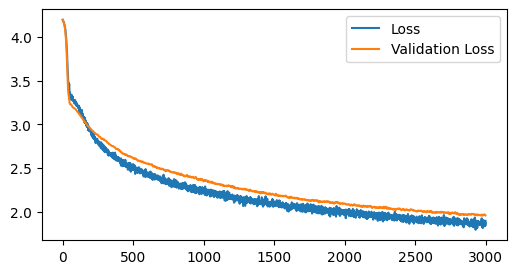

In [5]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) # this is a list of linear layers
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx:    # iterating over hidden layers
            x = F.gelu(hidden(x))  # applying each hidden layer
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(emb_size=10, hidden_size=128, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Much deeper network (20 layers)

Millions of parameters: 0.37
Epoch ___0 - Loss: 4.204
Epoch _300 - Loss: 3.030
Epoch _600 - Loss: 2.701
Epoch _900 - Loss: 2.579
Epoch 1200 - Loss: 2.501
Epoch 1500 - Loss: 2.480
Epoch 1800 - Loss: 2.460
Epoch 2100 - Loss: 2.393
Epoch 2400 - Loss: 2.389
Epoch 2700 - Loss: 2.360


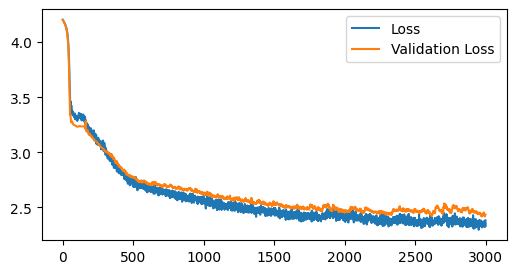

In [5]:
class Model(nn.Module):  # Same model class as before
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx:
            x = F.gelu(hidden(x))
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=20).to(device)  # increased to 20 layers 
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

The network with 20 hidden layers is unable to train effectively, thats because the derivatives don't flow well between the layers

# Residual connections

Millions of parameters: 0.37
Epoch ___0 - Loss: 5.457
Epoch _300 - Loss: 2.282
Epoch _600 - Loss: 1.944
Epoch _900 - Loss: 1.761
Epoch 1200 - Loss: 1.715
Epoch 1500 - Loss: 1.630
Epoch 1800 - Loss: 1.569
Epoch 2100 - Loss: 1.551
Epoch 2400 - Loss: 1.576
Epoch 2700 - Loss: 1.511


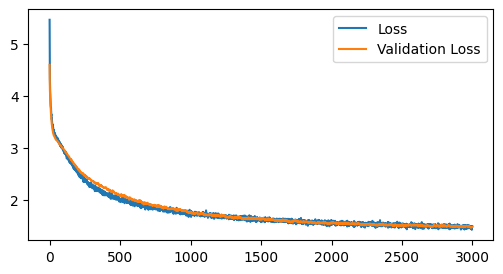

In [6]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx: 
            x = x + F.gelu(hidden(x))  # added skip connection 
        return self.fc2(x)
    

device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=20).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

In a standard layer, `x = linear(x)` completely transforms the input, which can make learning identity mappings harder. With residual connections, `x = x + linear(x)`, allowing the network to retain the original input while learning incremental changes. This improves gradient flow, facilitates identity learning, and enhances stability, especially in deep networks.

# Deeper (56 layers) 

Millions of parameters: 0.96
Epoch ___0 - Loss: 11324.800
Epoch _300 - Loss: 3.410
Epoch _600 - Loss: 3.183
Epoch _900 - Loss: 3.090
Epoch 1200 - Loss: 2.998
Epoch 1500 - Loss: 2.912
Epoch 1800 - Loss: 2.797
Epoch 2100 - Loss: 2.711
Epoch 2400 - Loss: 2.653
Epoch 2700 - Loss: 2.490


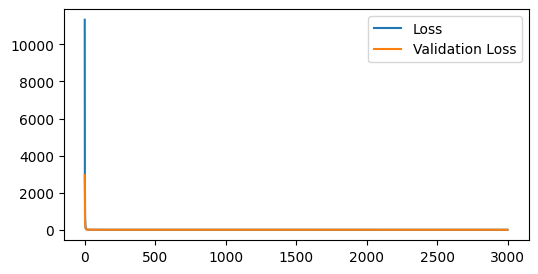

In [7]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx: 
            x = x + F.gelu(hidden(x))  
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=56).to(device)  # increased to 56 layers
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Normalization

Deeper networks allow for more layers, but often result in high loss initially. While we previously addressed this by decreasing parameter values at initialization, going too low can cause excessively small values. To prevent this, we normalize the neurons using layer normalization, ensuring a mean of 0 and standard deviation of 1. 

Millions of parameters: 0.96
Epoch ___0 - Loss: 4.344
Epoch _300 - Loss: 1.971
Epoch _600 - Loss: 1.663
Epoch _900 - Loss: 1.540
Epoch 1200 - Loss: 1.517
Epoch 1500 - Loss: 1.434
Epoch 1800 - Loss: 1.433
Epoch 2100 - Loss: 1.382
Epoch 2400 - Loss: 1.387
Epoch 2700 - Loss: 1.303


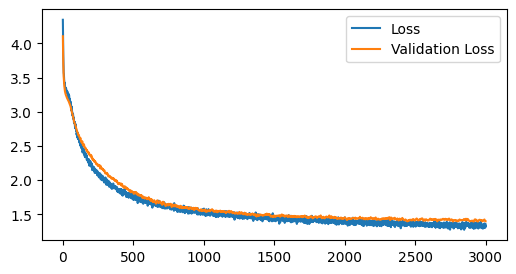

In [11]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        self.norm = nn.LayerNorm(hidden_size)  # added batch norm

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx: 
            x = x + self.norm(F.gelu(hidden(x)))  
        x = self.norm(x)
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=56).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

In [9]:
string = "             \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    model.eval()
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")
    model.train()


             
KING RICHARD I have your worships.

KING HICRINT:
Sacks hear him, to sound, disther a come; Reaces did and thee
Edward they'll fight
And to my head, then.

MONG HENRY VI:
Night
My valoms face never Edward me leavail'd strength
aniress, and you known.

HENRY VI say,
But that was means looks.

YOMPERIA:
Mestines; s

finally the text generated from the model makes some sense

# WAYY TOO DEEP
Just for fun lets try way more layers

In [12]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        self.norm = nn.BatchNorm1d(hidden_size)  

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx: 
            x = x + self.norm(F.gelu(hidden(x)))  
        return self.fc2(self.norm(x))


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=200).to(device)  # increased to 200 layers
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

Millions of parameters: 3.34
Epoch ___0 - Loss: 4.288


KeyboardInterrupt: 

# Limits to scale
The model clearly has problems backpropagating the gradients effectively. You may be able to make it work with some weird trick but there are solutions that scale much better. 